In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append('../')

## Sampler (идея, цель, примеры использования)

### Идея:

бесконечный источник данных из того же распределения, что и данные пришедшие на валидацию. Реализовываться это может подкапотом как угодно.

### Цель:

у некоторых моделей есть ограничения на *resampling* данных. Данный класс позволяет абстрагироваться от этих тонкостей, предоставляя единый интерфейс, плюс единая обертка над данными.


### Типичные примеры исполльзования

In [19]:
# Данные
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from IPython.display import display


X, y = make_classification(n_samples=100, n_classes=2,
                           n_features=3, n_informative=2,
                           n_redundant=0, random_state=0)
X = pd.DataFrame(X)
y = pd.Series(y)
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


display(X_train[:3])
display(X_test[:3])

,0,1,2
23,0.955084,1.079619,-1.621842
37,-0.903344,0.399046,1.794451
9,-1.273960,-0.466419,-0.043784


,0,1,2
49,2.341376,0.693773,1.470499
61,-1.457090,2.259309,0.486681
5,-1.203742,0.523891,-0.289788


In [32]:
# Создаем sampler
from sbe_vallib import SupervisedSampler

sampler = SupervisedSampler(train={'X': X_train, 'y_true': y_train},
                            oos = {'X': X_test, 'y_true': y_test})

In [33]:
# Получаем resampling версию данных

sampler.set_state(seed=5, gen_method='bootstrap')

display(sampler.train['X'][:4])
display(sampler.oos['X'][:4])


,0,1,2
23,0.955084,1.079619,-1.621842
37,-0.903344,0.399046,1.794451
9,-1.273960,-0.466419,-0.043784
77,-0.136509,-0.297791,0.733900


,0,1,2
11,0.313381,1.211145,1.120735
22,-1.285329,-0.944446,-1.308192
49,2.341376,0.693773,1.470499
22,-1.285329,-0.944446,-1.308192


In [34]:
# Получаем исходные данные

sampler.reset()

display(sampler.train['X'][:4])
display(sampler.oos['X'][:4])

,0,1,2
23,0.955084,1.079619,-1.621842
37,-0.903344,0.399046,1.794451
9,-1.273960,-0.466419,-0.043784
77,-0.136509,-0.297791,0.733900


,0,1,2
49,2.341376,0.693773,1.470499
61,-1.457090,2.259309,0.486681
5,-1.203742,0.523891,-0.289788
34,0.923281,-0.132881,-1.308135


## Scorer (идея, цель, примеры использования)

### Идея:

Идея этого класса - посчитать скопом заранее заданные метрики при вызове метода ```scorer.score()```

### Цель:

Причина появления: модели могут оцениваются самыми разными способами, все не уложить в тип ```func(y_true, y_pred)``` (*например YOLO*). С помощью этого класса абстрагируемся от этого, оставляя реализацию в нестандартных случаях на валидатора.


In [43]:
# создаем scorer
from sbe_vallib import BinaryScorer
from sbe_vallib.validation.utils.metrics import BINARY_METRICS

scorer = BinaryScorer(metrics=BINARY_METRICS, cutoff=0.1)

In [44]:
list(BINARY_METRICS.keys())

['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'gini']

### Типичные примеры исполльзования

In [45]:
# для начала создадим модель

from sklearn.linear_model import LogisticRegression

sampler.reset()
model = LogisticRegression().fit(sampler.train['X'], sampler.train['y_true'])

In [46]:
scorer.score(sampler.oos['y_true'], model.predict_proba(sampler.oos['X']))

{'accuracy_score': 0.7,
 'precision_score': 0.6363636363636364,
 'recall_score': 0.9333333333333333,
 'f1_score': 0.7567567567567568,
 'gini': 0.8844444444444444}

## Test (идея, цель, примеры использования)

### Идея:

Функция, которая реализует подсчет теста и его оформление. На эту функцию накладываются ограничения на сигнатуру: 

- функция как минимум должна принимать параметры ```model, scorer, sampler, **kwargs``` 
- функция должна выдать результат работы в следующем формате (привет SberDS)
    ```
    {
        "semaphore": str one of {"gray", "green", "yellow", "red"},
        "result_dict": python object,
        "result_dataframes": List[pd.DataFrame],
        "result_plots": List[plt.figure],
    }
    ```
    где,
    - "semaphore" -- светофор выставленный за тест
    - "result_dict" -- python object, который валидатор посчитает полезным для дальнейшего использования
    - "result_dataframes" -- список таблиц, которые будут отражены в агрегированном excel файле
    - "result_plots" -- список рисунков, которые будут отражены в агрегированном excel файле.
- ```sampler``` это единственный источник данных


### Цель:

Провести кастомный тест или из методики


In [47]:
# напишем какой-то тупой тест

def custom_test(model, scorer, sampler, threshold = 1, **kwargs):
    semaphore = 'green'
    if len(sampler.train['X']) < threshold:
        semaphore = 'red'
    
    df_table = pd.DataFrame({'len': [len(sampler.train['X'])],
                             'semaphore': semaphore})
    
    return {
        "semaphore": semaphore,
        "result_dict": {'train_shape':sampler.train['X'].values.shape},
        "result_dataframes": [df_table],
        "result_plots": [],
    }

custom_test(model, scorer, sampler, threshold=5, r_u_angry='True')

{'semaphore': 'green',
 'result_dict': {'train_shape': (70, 3)},
 'result_dataframes': [   len semaphore
  0   70     green],
 'result_plots': []}

## Pipeline (идея, цель, примеры использования)

### Идея:

Отражение понятия методики в нашей бибилиотеке. То есть ```Pipeline``` это список тестов с указанными параметрами и дополнительными метаданными для формирования отчета (*цель теста, интерпретация, способ агрегации блоков*).

### Цель:

Капсулировать всю информацию из методички


## Реализация:

```Pipeline``` - это excel-файл с двумя страницами
- первая страница -- информация о тестах
- вторая страница -- информация о блоках.

In [49]:
pd.read_excel('../sbe_vallib/validation/table/pipelines/Config_31.xlsx', sheet_name="tests_config")

,import_path,test_key,block_key,Название блока,Название,Цель,Интерпретация,Границы красный,Границы желтый,Границы зеленый,params
0,sbe_vallib.validation.table.general_tests.data...,test_factor_psi,data_quality,Качество данных,Тест 1.2 Анализ однородности выборок out-of-sa...,Убедиться в однородности выборки (в разрезе фа...,Высокое значение PSI свидетельствует о различи...,NaN,"PSI ≥ 0,2","PSI < 0,2","{""merge_upto_quantile"": 0.05,\n ""rounding_prec..."
1,sbe_vallib.validation.table.general_tests.mode...,test_ci,model_quality,Качество модели,Тест 2.2 Доверительный интервал ключевой метри...,Наглядно изобразить уровень статистической пог...,Данный тест позволяет оценить фактический разб...,NaN,NaN,NaN,"{""n_iter"": 200, ""use_predict_proba"": True}"


In [50]:
pd.read_excel('../sbe_vallib/validation/table/pipelines/Config_31.xlsx', sheet_name="agg_config")

,block_key,func
0,data_quality,sbe_vallib.validation.worst_semaphore
1,model_quality,sbe_vallib.validation.worst_semaphore
2,calibration,sbe_vallib.validation.worst_semaphore
3,specification,sbe_vallib.validation.worst_semaphore
4,stability,sbe_vallib.validation.worst_semaphore


## Validation (идея, цель, примеры использования)

### Идея:

Запуск всех тестов из списка и аггрегация их результатов.

### Цель:

Удобный запуск тестов


<img src="./images/uml_vallib.jpg" alt="fishy" class="bg-primary mb-1" width="500px">

In [80]:
# способ прокидывания custim_test'ов в validation

from sbe_vallib import Validation

custom_tests = {
    "custom_1": {"block": "data_quality", "callable": custom_test, "params": {"threshold": 5000}}
}


validor = Validation(model,
                     sampler,
                     scorer,
                     custom_tests=custom_tests,
                     pipeline='../sbe_vallib/validation/table/pipelines/Config_31.xlsx')
res = validor.validate()

In [81]:
list(res.keys())

['test_factor_psi', 'test_ci', 'custom_1']

In [82]:
res['test_factor_psi']['result_dataframes'][0]

,0,1,2
psi,6.579536,4.066337,2.684069
feat_type,Continuous,Continuous,Continuous
bin_count,21,21,21
hist_train,0.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.00...,0.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.00...,0.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.000 ;4.00...
hist_oos,0.000 ;0.000 ;5.000 ;5.000 ;1.000 ;2.000 ;0.00...,0.000 ;1.000 ;1.000 ;0.000 ;4.000 ;2.000 ;0.00...,1.000 ;0.000 ;1.000 ;2.000 ;2.000 ;1.000 ;3.00...
bins,"[-inf, -3.19884, -2.22186, -1.27338, -1.12875,...","[-inf, -2.77309, -1.6755, -1.38286, -1.18836, ...","[-inf, -3.58792, -2.38039, -1.62146, -1.2434, ..."
feature,0,1,2
semaphore,red,red,red


In [20]:
import physt
import numpy as np

choice = np.random.randint(0, 2, size=1000)
samples = choice * np.random.normal(10, 1, size=1000) + (1 - choice) * np.random.normal(10.5, 2, size=1000)

<AxesSubplot: xlabel='axis0'>

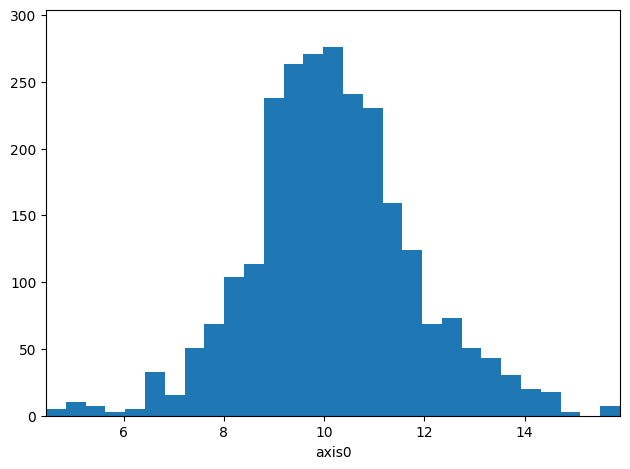

In [29]:
res = physt.histogram(samples, 'knuth')
res.plot(density=True)

In [30]:
res.bins

array([[ 4.4513002 ,  4.84626924],
       [ 4.84626924,  5.24123828],
       [ 5.24123828,  5.63620732],
       [ 5.63620732,  6.03117635],
       [ 6.03117635,  6.42614539],
       [ 6.42614539,  6.82111443],
       [ 6.82111443,  7.21608347],
       [ 7.21608347,  7.61105251],
       [ 7.61105251,  8.00602155],
       [ 8.00602155,  8.40099058],
       [ 8.40099058,  8.79595962],
       [ 8.79595962,  9.19092866],
       [ 9.19092866,  9.5858977 ],
       [ 9.5858977 ,  9.98086674],
       [ 9.98086674, 10.37583577],
       [10.37583577, 10.77080481],
       [10.77080481, 11.16577385],
       [11.16577385, 11.56074289],
       [11.56074289, 11.95571193],
       [11.95571193, 12.35068096],
       [12.35068096, 12.74565   ],
       [12.74565   , 13.14061904],
       [13.14061904, 13.53558808],
       [13.53558808, 13.93055712],
       [13.93055712, 14.32552615],
       [14.32552615, 14.72049519],
       [14.72049519, 15.11546423],
       [15.11546423, 15.51043327],
       [15.51043327,